# Определение стоимости автомобилей
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План проекта

**Подготовка данных:**
* Читаем датасет;
* Смотрим пропуски, заполняем их;
* Найдем дубликаты и удалим их;
* Избавимся от аномалий и вбросов;
* Оставим только необходимые столбцы для обучения моделей.

**Обучние моделей:**
* Обучаем три модели;
* Работа с ОНЕ и ОЕ.

**Анализ моделей:**
* Приводим результаты обучения в таблицу;
* Делаем выводы, выбираем лучшую модель.

**Тест лучшей модели**

**Выводы**



## Подготовка данных

In [1]:
#так как у меня не была установлена библиотека catboost в колабе, первым делом устанавливаю ее:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

#библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st

#методы
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder)

#модели
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as ltb
from lightgbm import LGBMRegressor

#графики
import matplotlib.pyplot as plt
import seaborn as sns

#дополнительные
RANDOM_STATE=12345

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


Посмотрим какие данные есть в датасете

In [2]:
data = pd.read_csv('/content/autos.csv')
display(data.head(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Найдем пропуски:

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски есть в пяти столбцах:
1. тип кузова,
2. тип коробки передач,
3. модель машины,
4. тип топлива,
5. была ли машина в ремонте.
Это важные типы данных и они влияют на стоимость машины. Заполним данные нулями.

In [5]:
data['Model'] = data['Model'].fillna('unknow')
data['FuelType'] = data['FuelType'].fillna('unknow')
data['Repaired'] = data['Repaired'].fillna('unknow')

data['Gearbox'] = data['Gearbox'].fillna(data.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
data['VehicleType'] = data['VehicleType'].fillna(data.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknow,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим дубликаты:

In [6]:
print('Датасет содержит', (data.duplicated().sum()), 'дубликата')

Датасет содержит 4 дубликата


Удалим их:

In [7]:
data = data.drop_duplicates().reset_index(drop=True)
print('Датасет содержит', (data.duplicated().sum()), 'дубликатов')

Датасет содержит 0 дубликатов


Посмотрим числовые описания данных:

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Выяснили минимальные и максимальные показатели. Смущает
1. макс.показатель года выпуска,
2. одинаковые данные в квантилях 50%, 75%, максимальное,
3. мин.мощность = 0.

Разберемся с ними.

In [9]:
years_reg = data.pivot_table(index = 'RegistrationYear', values ='Power', aggfunc = 'count').sort_values(by='RegistrationYear', ascending=False)
print(years_reg)

years_reg.plot(grid=True, kind = 'bar', color = 'red', alpha = 0.5, figsize=(100, 100))
plt.title('Выпуск по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество')
plt.show()

                  Power
RegistrationYear       
9999                 26
9996                  1
9450                  1
9229                  1
9000                  3
...                 ...
1200                  1
1111                  3
1039                  1
1001                  1
1000                 37

[151 rows x 1 columns]


Свод и график говорят о вбросах в данных - год регистрации не может быть 1000 или 9999. Очистим данные: возьмем период от 1960-2016 годов.

In [10]:
data = data[(data['RegistrationYear'] >= 1960) & (data['RegistrationYear'] <= 2016)]
display(data.head())

data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknow,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 339413 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        339413 non-null  object
 1   Price              339413 non-null  int64 
 2   VehicleType        339413 non-null  object
 3   RegistrationYear   339413 non-null  int64 
 4   Gearbox            339413 non-null  object
 5   Power              339413 non-null  int64 
 6   Model              339413 non-null  object
 7   Kilometer          339413 non-null  int64 
 8   RegistrationMonth  339413 non-null  int64 
 9   FuelType           339413 non-null  object
 10  Brand              339413 non-null  object
 11  Repaired           339413 non-null  object
 12  DateCreated        339413 non-null  object
 13  NumberOfPictures   339413 non-null  int64 
 14  PostalCode         339413 non-null  int64 
 15  LastSeen           339413 non-null  object
dtypes: int64(7), object(

Посмотрим подозрительный пробег:

           RegistrationYear
Kilometer                  
150000               227546
125000                35037
100000                14375
90000                 11184
80000                  9747
70000                  8351
60000                  7272
50000                  6051
40000                  4811
30000                  4308
20000                  3801
10000                  1121
5000                   5809


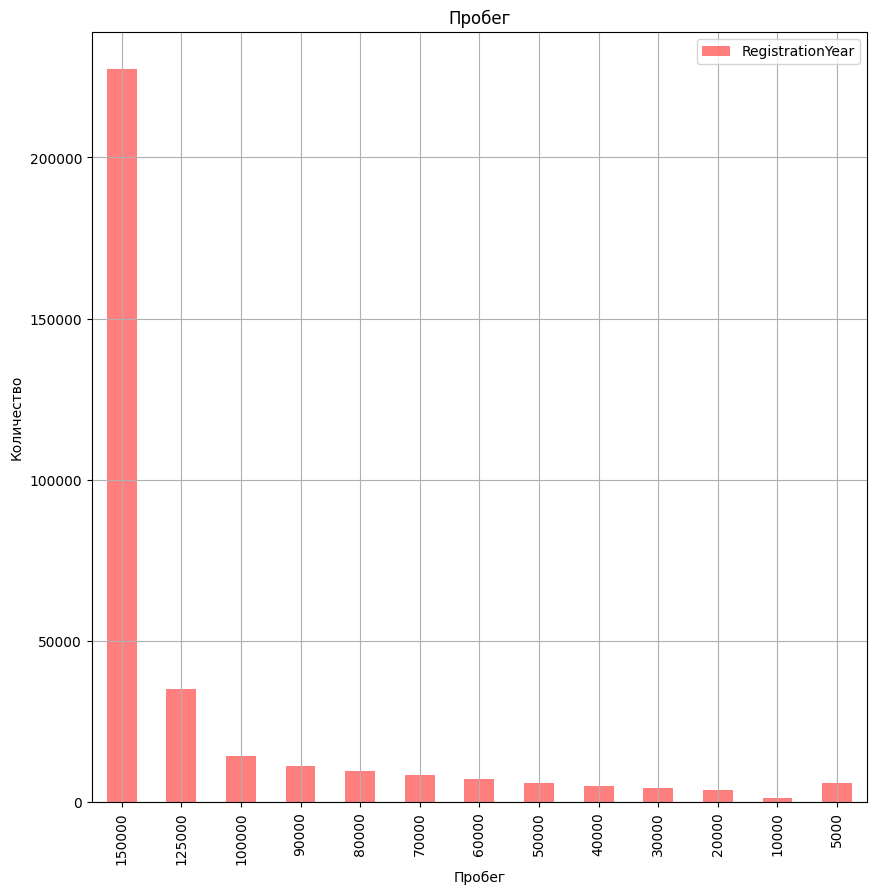

           RegistrationYear   count        price
Kilometer                                       
5000                 2000.0    5809  2750.355999
10000                2013.0    1121  9650.554862
20000                2012.0    3801  8645.543541
30000                2012.0    4308  9324.408078
40000                2011.0    4811  9673.445022
50000                2010.0    6051  9154.613287
60000                2009.0    7272  8607.634213
70000                2008.0    8351  7967.217100
80000                2008.0    9747  7276.389864
90000                2007.0   11184  6707.583870
100000               2006.0   14375  5995.553670
125000               2004.0   35037  5165.297657
150000               2001.0  227546  3397.801873


In [11]:
km = data.pivot_table(index = 'Kilometer', values ='RegistrationYear', aggfunc = 'count').sort_values(by='Kilometer', ascending=False)
print(km)

km.plot(grid=True, kind = 'bar', color = 'red', alpha = 0.5, figsize=(10, 10))
plt.title('Пробег')
plt.xlabel('Пробег')
plt.ylabel('Количество')
plt.show()

km_years = data.groupby('Kilometer').agg(RegistrationYear = ('RegistrationYear', 'median'), count = ('RegistrationYear', 'count'), price = ("Price", 'mean'))
print(km_years)

Оставляем данные в исходном виде: основная часть машин 2002 года. За десятилетие похоже на реальный пробег. И стоимость очень доступная.

Очистим датасет от выбросов мощности:

In [12]:
data = data[(data['Power'] > 0) & (data['Power'] < 1000)]
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 302876 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        302876 non-null  object
 1   Price              302876 non-null  int64 
 2   VehicleType        302876 non-null  object
 3   RegistrationYear   302876 non-null  int64 
 4   Gearbox            302876 non-null  object
 5   Power              302876 non-null  int64 
 6   Model              302876 non-null  object
 7   Kilometer          302876 non-null  int64 
 8   RegistrationMonth  302876 non-null  int64 
 9   FuelType           302876 non-null  object
 10  Brand              302876 non-null  object
 11  Repaired           302876 non-null  object
 12  DateCreated        302876 non-null  object
 13  NumberOfPictures   302876 non-null  int64 
 14  PostalCode         302876 non-null  int64 
 15  LastSeen           302876 non-null  object
dtypes: int64(7), object(

In [13]:
data = data[(data['Price'] != 0)]
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknow,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 296479 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        296479 non-null  object
 1   Price              296479 non-null  int64 
 2   VehicleType        296479 non-null  object
 3   RegistrationYear   296479 non-null  int64 
 4   Gearbox            296479 non-null  object
 5   Power              296479 non-null  int64 
 6   Model              296479 non-null  object
 7   Kilometer          296479 non-null  int64 
 8   RegistrationMonth  296479 non-null  int64 
 9   FuelType           296479 non-null  object
 10  Brand              296479 non-null  object
 11  Repaired           296479 non-null  object
 12  DateCreated        296479 non-null  object
 13  NumberOfPictures   296479 non-null  int64 
 14  PostalCode         296479 non-null  int64 
 15  LastSeen           296479 non-null  object
dtypes: int64(7), object(

Посмотрим корреляцию показателей. Но сначала очистим датасет от лишних числовых данных.
1. RegistrationMonth — месяц регистрации автомобиля,
2. NumberOfPictures — количество фотографий автомобиля,
3. PostalCode — почтовый индекс владельца анкеты (пользователя).

In [14]:
data_corr=data.drop(['NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1)
data_corr.corr(method ='spearman')

<ipython-input-14-7ad868730228>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr.corr(method ='spearman')


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.665225,0.524102,-0.367787
RegistrationYear,0.665225,1.000000,0.189444,-0.383074
Power,0.524102,0.189444,1.000000,0.121246
Kilometer,-0.367787,-0.383074,0.121246,1.000000


Видна зависимость цены от года регистрации машины и ее мощности.

**В итоге:**
1. Изучили данные, нашли и удалили вборсы по годам регистрации.
2. Заполнили категориальные признаки значением "unknow".
3. Изучили пробег. Дешевых машин он больше.
4. Посмотерли зависимость числовых данных друг от друга - корреляцию.


## Обучение моделей

Посмотрим, какие данные нам помогут составить представление о цене, а остальные удалим.

1. Оставляем:
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет

2. Удаляем:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [15]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
display(data.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknow,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknow
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Делим на выборки датасет:
1. Определяем целевой признак и остальные признаки.
2. Разделяю на тренировочную валидационную и тестовую выборки.

In [16]:
#выделяю признаки и целевой признак:
features_original = data.drop('Price', axis=1)
target = data['Price']


train_valid, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=RANDOM_STATE)

features_train = train.drop(['Price'], axis=1)
target_train = train['Price']

features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price']

features_test = test.drop(['Price'], axis=1)
target_test = test['Price']


for i in [features_train, features_valid, features_test]:
    print(i.shape)

print()

(177887, 9)
(59296, 9)
(59296, 9)



3. Определяю категориальные и числовые признаки.
4. Кодирую данные с помощью категориальные данные с помощью ОНЕ

In [17]:
categorial = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer']

features_ohe = pd.get_dummies(features_original, drop_first=True)

features_train_valid_ohe, features_test_ohe, target_train_valid_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=0.2,
                                                                                            random_state=RANDOM_STATE)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_train_valid_ohe,
                                                                                            target_train_valid_ohe,
                                                                                            test_size=0.25,
                                                                                            random_state=RANDOM_STATE)

train, valid = train_test_split(train_valid, test_size=0.25, random_state=RANDOM_STATE)


for i in [features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe, features_test_ohe, target_test_ohe]:
    print(i.shape)

print()

display(features_train_ohe.head(3))

(177887, 308)
(59296, 308)
(177887,)
(59296,)
(59296, 308)
(59296,)



,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknow,Repaired_yes
116182,1995,150,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
38714,1998,75,100000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133862,2012,150,20000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


5. Кодирую категориальные данные с помощью ОЕ.

In [18]:
encoder = OrdinalEncoder()

features_train_oe = categorial
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

features_valid_oe = categorial
features_valid_oe = pd.DataFrame(encoder.fit_transform(features_valid),
                                columns=features_valid.columns,
                                index=features_valid.index)

features_test_oe = categorial
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)

target_train_oe = target_train.copy()
target_valid_oe = target_valid.copy()
target_test_oe = target_test.copy()

for i in [features_train_oe, features_valid_oe, target_train_oe, target_valid_oe, features_test_oe, target_test_oe]:
    print(i.shape)

print()

display(features_train_oe.head(3))

(177887, 9)
(59296, 9)
(177887,)
(59296,)
(59296, 9)
(59296,)



,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
116182,4.0,35.0,0.0,149.0,20.0,12.0,7.0,1.0,1.0
38714,2.0,38.0,1.0,74.0,166.0,10.0,6.0,28.0,0.0
133862,0.0,52.0,1.0,149.0,14.0,2.0,6.0,19.0,0.0


Обучим первую модель - CatBoostClassifier. На двух выборках - ОНЕ и ОЕ.

In [19]:
%%time

model1 = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=100)
model1.fit(features_train_ohe, target_train_ohe)


Learning rate set to 0.092833
0:	learn: 4339.2251273	total: 139ms	remaining: 2m 19s
100:	learn: 1800.4450983	total: 5.55s	remaining: 49.4s
200:	learn: 1706.6166744	total: 9.19s	remaining: 36.5s
300:	learn: 1656.8759147	total: 11.4s	remaining: 26.4s
400:	learn: 1624.3703020	total: 13.4s	remaining: 20.1s
500:	learn: 1599.6832754	total: 15.6s	remaining: 15.5s
600:	learn: 1579.6391258	total: 17.6s	remaining: 11.7s
700:	learn: 1564.1934345	total: 20.4s	remaining: 8.72s
800:	learn: 1548.8795043	total: 23.4s	remaining: 5.82s
900:	learn: 1535.5392961	total: 25.6s	remaining: 2.81s
999:	learn: 1523.7887691	total: 27.7s	remaining: 0us
CPU times: user 43.7 s, sys: 1.21 s, total: 44.9 s
Wall time: 30.3 s


In [20]:
%%time

pred_valid1 = model1.predict(features_valid_ohe)

CPU times: user 366 ms, sys: 13.8 ms, total: 380 ms
Wall time: 208 ms


In [21]:
rsme_cat_ohe = mean_squared_error(target_valid_ohe, pred_valid1) ** .5

print('RMSE:', rsme_cat_ohe)

RMSE: 1586.562075705074


In [22]:
%%time

model11 = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=100)
model11.fit(features_train_oe, target_train_oe)

Learning rate set to 0.092833
0:	learn: 4332.2986231	total: 28.2ms	remaining: 28.2s
100:	learn: 1800.8084389	total: 2.46s	remaining: 21.9s
200:	learn: 1708.6387568	total: 6s	remaining: 23.9s
300:	learn: 1657.0625201	total: 8.71s	remaining: 20.2s
400:	learn: 1625.0205645	total: 11s	remaining: 16.5s
500:	learn: 1599.0176663	total: 13.4s	remaining: 13.3s
600:	learn: 1579.1048188	total: 15.7s	remaining: 10.4s
700:	learn: 1561.1079648	total: 19.6s	remaining: 8.36s
800:	learn: 1546.8097460	total: 21.9s	remaining: 5.44s
900:	learn: 1533.6985173	total: 24.2s	remaining: 2.66s
999:	learn: 1521.5201196	total: 26.5s	remaining: 0us
CPU times: user 45.1 s, sys: 1.03 s, total: 46.1 s
Wall time: 26.8 s


In [23]:
%%time

pred_valid11 = model11.predict(features_valid_oe)

CPU times: user 131 ms, sys: 1.97 ms, total: 133 ms
Wall time: 72.7 ms


In [24]:
rsme_cat_oe = mean_squared_error(target_valid_oe, pred_valid11) ** .5

print('RMSE:', rsme_cat_oe)

RMSE: 1711.5993563152751


Обучим вторую модель - LightGBMRegressor. На двух выборках - ОНЕ и ОЕ.

In [25]:
%%time

model2 = LGBMRegressor(random_state=RANDOM_STATE)
model2.fit(features_train_ohe, target_train_ohe)

CPU times: user 5.09 s, sys: 410 ms, total: 5.5 s
Wall time: 3.7 s


LGBMRegressor(random_state=12345)

In [26]:
%%time

pred_valid2 = model2.predict(features_valid_ohe)

CPU times: user 770 ms, sys: 65.5 ms, total: 836 ms
Wall time: 785 ms


In [27]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, pred_valid2) ** .5

print('RMSE:', rsme_lgbmr_ohe)

RMSE: 1674.0660913327536


In [28]:
%%time

model22 = LGBMRegressor(random_state=RANDOM_STATE)
model22.fit(features_train_oe, target_train_oe)

CPU times: user 2.92 s, sys: 25.7 ms, total: 2.94 s
Wall time: 1.95 s


LGBMRegressor(random_state=12345)

In [29]:
%%time

pred_valid22 = model22.predict(features_valid_oe)

CPU times: user 592 ms, sys: 2.94 ms, total: 595 ms
Wall time: 325 ms


In [30]:
rsme_lgbmr_oe = mean_squared_error(target_valid_oe, pred_valid22) ** .5

print('RMSE:', rsme_lgbmr_oe)

RMSE: 1770.7374370414313


Обучим третью модель - RandomForestRegressor. На двух выборках - ОНЕ и ОЕ.

In [31]:
%%time

model3 = RandomForestRegressor(random_state=RANDOM_STATE,n_estimators = 91, criterion = "squared_error")
model3.fit(features_train_ohe, target_train_ohe)

CPU times: user 6min 8s, sys: 1.67 s, total: 6min 10s
Wall time: 6min 12s


RandomForestRegressor(n_estimators=91, random_state=12345)

In [32]:
%%time

pred_valid3 = model3.predict(features_valid_ohe)

CPU times: user 3.36 s, sys: 64.8 ms, total: 3.42 s
Wall time: 3.47 s


In [33]:
rsme_rf_ohe = mean_squared_error(target_valid_ohe, pred_valid3) ** .5

print('RMSE:', rsme_rf_ohe)

RMSE: 1585.5081911596142


In [34]:
%%time

model33 = RandomForestRegressor(random_state=RANDOM_STATE,n_estimators = 91, criterion = "squared_error")
model33.fit(features_train_oe, target_train_oe)

CPU times: user 49.7 s, sys: 1.33 s, total: 51 s
Wall time: 51 s


RandomForestRegressor(n_estimators=91, random_state=12345)

In [35]:
%%time

pred_valid33 = model33.predict(features_valid_oe)

CPU times: user 2.32 s, sys: 7 ms, total: 2.33 s
Wall time: 2.33 s


In [36]:
rsme_rf_oe = mean_squared_error(target_valid_oe, pred_valid33) ** .5

print('RMSE:', rsme_rf_oe)

RMSE: 1769.7366168034587


**В итоге:**
1. Обучили три модели двумя разными способами.
2. ОНЕ при любой модели дает лучшие результаты.

## Анализ моделей

Соберем таблицу по всем необходимым показателям:

In [37]:
frame_all = pd.DataFrame({'Модель': ['CatBoostRegressor_OHE', 'CatBoostRegressor_OHE', 'LGBMRegressor_OHE',
                          'LGBMRegressor_OE', 'RandomForestRegressor_OHE', 'RandomForestRegressor_OE'],
                          'RMSE': [rsme_cat_ohe, rsme_cat_oe, rsme_lgbmr_ohe, rsme_lgbmr_oe, rsme_rf_ohe, rsme_rf_oe],
                          'Время обучения' : ['30.6 s', '24.8 s', '29.6 s', '4.35 s', '5min 12s', '37.3 s' ],
                          'Время предсказания' : ['130 ms', '59.9 ms', '825 ms', '448 ms', '3.41 s', '2.05 s']})


print(frame_all)

                      Модель         RMSE Время обучения Время предсказания
0      CatBoostRegressor_OHE  1586.562076         30.6 s             130 ms
1      CatBoostRegressor_OHE  1711.599356         24.8 s            59.9 ms
2          LGBMRegressor_OHE  1674.066091         29.6 s             825 ms
3           LGBMRegressor_OE  1770.737437         4.35 s             448 ms
4  RandomForestRegressor_OHE  1585.508191       5min 12s             3.41 s
5   RandomForestRegressor_OE  1769.736617         37.3 s             2.05 s


**Итог:**
1. Были выбраны 3 модели для обучения - CatBoostRegressor, LGBMRegressor, RandomForestRegressor.
2. Для кодирования данных были применены методы ОНЕ(создание признаков 0/1) и ОЕ(переводим категорию в число).
3. При обучении все модели показали хороший результат - меньше установленных 2500.
4. Самой лучшей моделью считаю CatBoostRegressor с примененным методом кодировки OHE. у нее минимальная RMSE и ниже среднего время обучения и предсказания.

## Тестирование лучшей модели

Тестируем CatBoostRegressor с примененным методом кодировки OHE:

In [38]:
%%time

model_test = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=100)
model_test.fit(features_train_ohe, target_train_ohe)

Learning rate set to 0.092833
0:	learn: 4339.2251273	total: 34.1ms	remaining: 34s
100:	learn: 1800.4450983	total: 2.35s	remaining: 20.9s
200:	learn: 1706.6166744	total: 4.5s	remaining: 17.9s
300:	learn: 1656.8759147	total: 8.18s	remaining: 19s
400:	learn: 1624.3703020	total: 10.3s	remaining: 15.3s
500:	learn: 1599.6832754	total: 12.3s	remaining: 12.3s
600:	learn: 1579.6391258	total: 14.5s	remaining: 9.6s
700:	learn: 1564.1934345	total: 16.6s	remaining: 7.06s
800:	learn: 1548.8795043	total: 20.2s	remaining: 5.03s
900:	learn: 1535.5392961	total: 22.4s	remaining: 2.46s
999:	learn: 1523.7887691	total: 24.5s	remaining: 0us
CPU times: user 43.7 s, sys: 1.05 s, total: 44.7 s
Wall time: 25.9 s


In [39]:
%%time

pred_test = model_test.predict(features_test_ohe)

CPU times: user 520 ms, sys: 28.9 ms, total: 549 ms
Wall time: 390 ms


In [40]:
rsme_cat_ohe = mean_squared_error(target_test_ohe, pred_test) ** .5

print('RMSE на тестовой выборке:', rsme_cat_ohe)

RMSE на тестовой выборке: 1589.5692116053713


RMSE меньше 2500 и значит ее можно презентовать заказчику.

## Выводы:
1. Были получены данные на основании которых нужно построить модель с предсказанием рыночной стоимости автомобиля клиентов. Перед работой данные пришлось скорректировать: заполнить пропуски, удалить вбросы.
2. После проведена оценка корреляции. Все стандартно - стоимость зависит от мощности и "возраста" машины.
3. Подобраны модели бустинга для обучения CatBoostRegressor, LGBMRegressor (как указано в задании) и выбарана простая модель RandomForestRegressor (выбрала основываясь на предыдущем положительном опыте работы с ней).
4. Для обучения данные категориальные данные были закодированы методами ОНЕ и ОЕ.
5. По итогам обучения все модели показали хороший результат. Лучше всего справилась модель CatBoostRegressor с примененным методом кодировки OHE. Ее взяли для тестирования.
6. При тестировании модели получили: RMSE = 1589 при пороге 2500, скорость обучения = 25 секунд, скорость предсказаний = 110 милисекундам.
7. Модель подходит заказчику по всем критериям.